## Spam Email Classifier with KNN using TF-IDF scores

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   The report file must be a well documented jupyter notebook, explaining the experiments you have performed, evaluation metrics and corresponding code. The code must run and be able to reproduce the accuracies, figures/graphs etc.
5.   For all the questions, you must create a train-validation data split and test the hyperparameter tuning on the validation set. Your jupyter notebook must reflect the same.
6.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

**Task: Given an email, classify it as spam or ham**

Given input text file ("emails.txt") containing 5572 email messages, with each row having its corresponding label (spam/ham) attached to it.

This task also requires basic pre-processing of text (like removing stopwords, stemming/lemmatizing, replacing email_address with 'email-tag', etc..).

You are required to find the tf-idf scores for the given data and use them to perform KNN using Cosine Similarity.

# CODE

### Import necessary libraries

In [1]:
import os
import re
import sys
import math
import time
import string
import random
import tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk.corpus
import nltk
nltk.download('punkt')
nltk.download('stopwords')
lemmer=nltk.WordNetLemmatizer()
stop_words=nltk.corpus.stopwords.words('english')

from sklearn.metrics import r2_score,confusion_matrix,recall_score,precision_score,f1_score,accuracy_score
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to /home/archit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/archit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load dataset

In [2]:
path = "./emails.txt"
data = pd.read_csv(path, sep='\t', header=None)
data.rename({0: 'label', 1:'mail_text'}, axis='columns', inplace=True)

### Preprocess data

In [3]:
def del_up(text):
    '''
        convert all uppercase letters to lowercase
        replace email address with 'email-tag'
        stop words removal
        lemming the words
    '''
    text = text.lower()
    if text in stop_words or len(text)<3 or text in string.punctuation:
        return False, text
    regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    if(re.fullmatch(regex, text)):
        return True, 'email-tag'
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»]))"
    if(re.fullmatch(url_regex, text)):
        return True, 'url-tag'
    if text.isalnum():
        return True, lemmer.lemmatize(text)
    return False, text


In [4]:
def tok_pun(sentence):
    token_list=[]
    sentence = re.sub(r"[,.;@#?!&$]+\ *", " ", sentence)
    for i in sentence.split():
        a,b=del_up(i)
        if a==True:
            token_list.append(b)
    return token_list

def label_it(label):
    if label == 'ham':
        return 0
    return 1

In [5]:
data['tokenized_text'] = data['mail_text'].apply(lambda x: tok_pun(x))
data["label_val"] = data["label"].apply(lambda x: label_it(x))

In [6]:
def unique_words_in_data(data):
    data.head()
    columns=[]
    for x in data['tokenized_text']:
        for y in x:
            if y not in columns:
                columns.append(y)
    return columns

def idf(data,unique_words):
    idf_dict={}
    N=len(data)
    for i in unique_words:
        count=0
        for x in data['tokenized_text']:
            if i in x:
                count=count+1
        idf_dict[i]=(math.log((N)/(count)))
    return idf_dict 

def tfidf(data,idf_dic):
    tfidf_array=[]
    temp_arr={}
    for i in range(len(data)):
        x=data
        temp_arr={}
        if len(x)==0:
            print(i)
            pass
        else:
            for y in x:
                if y not in temp_arr:
                    temp_arr[y]=0
                temp_arr[y]+=1
            
            for y in temp_arr:
                temp_arr[y]=math.log(1+temp_arr[y])*idf_dic[y]
    return temp_arr
    return tfidf_array

def tfidf2(data,idf_dic):
    tfidf_array=[]
    temp_arr={}
    for i in range(len(data)):
        x=data.loc[i]["tokenized_text"]
        temp_arr={}
        if len(x)==0:
            pass
            # print(i)
        else:
            for y in x:
                if y not in temp_arr:
                    temp_arr[y]=0
                temp_arr[y]+=1
            
            for y in temp_arr:
                temp_arr[y]=math.log(1+temp_arr[y])*idf_dic[y]
        tfidf_array.append(temp_arr)
    return tfidf_array


In [7]:
unique_words = unique_words_in_data(data)
len(unique_words)

7452

In [8]:
idf_dic=idf(data,unique_words)
# tfidf_array=tfidf(data,idf_dic)

In [9]:
data["tfidf"] = data["tokenized_text"].apply(lambda x: tfidf(x,idf_dic))

In [10]:
arr=[]
for i in range(len(data)):
    if len(data.loc[i]["tokenized_text"])==0:
        arr.append(i)
data = data.drop(arr)

### Split data

In [11]:
train_X, test_X, train_y, test_y = train_test_split(data["tfidf"], data['label_val'], train_size=0.8,random_state=0)
test_X, val_X, test_y, val_y = train_test_split(test_X,test_y, test_size=0.5,random_state=0)

### Train your KNN model (reuse previously iplemented model built from scratch) and test on your data

***1. Experiment with different distance measures [Euclidean distance, Manhattan distance, Hamming Distance] and compare with the Cosine Similarity distance results.***

In [12]:
def moderator(dic1,dic2):
    dic3={}
    dic4={}
    for x in dic1:
        dic3[x]=dic1[x]
        dic4[x]=0.0
    for x in dic2:
        dic3[x]=0.0
        dic4[x]=dic2[x]
    dic3=np.array(list(dic3.values()))
    dic4=np.array(list(dic4.values()))
    return dic3,dic4

In [44]:
def euclidean_distance(X,Y):
    X,Y=moderator(X,Y)
    return np.sqrt(np.sum((X - Y)**2))

def manhattan_distance(X,Y):
    X,Y=moderator(X,Y)
    return np.sum(np.abs(X - Y))

def hamming_distance(X,Y):
    X,Y=moderator(X,Y)
    return np.sum(X != Y)

def cosine_similarity_distance(X,Y):
    X,Y=moderator(X,Y)
    val=0.0
    a=0.0
    b=0.0
    for idx in range(len(X)):
        val=val+(X[idx]*Y[idx])
        a=a+(X[idx]*X[idx])
        b=b+(Y[idx]*Y[idx])
    if(a*b==0):
        return 0.0
    return 1.0 - (val / (math.sqrt(a*b)))

In [30]:
def predict_label(email_X,train_X,train_y,k_value,distance_metric,half=False):
    arr1=email_X
    arr2=[]
    scores={}
    for idx in train_X.keys():
        arr2=train_X[idx]
        scores[idx]=distance_metric(arr1,arr2)
    sorted_scores=sorted(scores.items(), key=lambda x:x[1], reverse=False)
    if half==True:
        return sorted_scores
    sorted_scores=sorted_scores[:k_value]
    spam_label=[]
    ham_label=[]
    cur_k=0
    for x in sorted_scores:
        if cur_k==k_value:
            break
        val=x[1]
        x=x[0]
        if train_y[x]==0:
            ham_label.append(val)
        else:
            spam_label.append(val)
        cur_k+=1
    if len(ham_label)>len(spam_label):
        return 0
    elif len(ham_label)<len(spam_label):
        return 1
    else:
        if ham_label[0]<spam_label[0]:
            return 1
        elif ham_label[0]>spam_label[0]:
            return 0
        else:
            return random.choice([0,1])


In [31]:
def my_knn_predict(test_X,train_X,train_y,k_value,distance_metric=cosine_similarity_distance,half=False):
    '''
        distance matrix allowed are:
            euclidean_distance,
            hamming_distance,
            manhattan_distance,
            cosine_similarity_distance(default)
    '''
    predicted_label={}
    for idx in test_X.keys():
        if(idx%100==0):
            print(idx,end="\r")
        predicted_label[idx]=predict_label(test_X[idx],train_X,train_y,k_value,distance_metric,half)
    print("done!")
    return predicted_label

In [32]:
def my_knn_accuracy(predicted_label,test_y):
    count=0
    for x in predicted_label.keys():
        if predicted_label[x]==test_y[x]:
            count+=1
    return count/len(predicted_label)

def my_knn_mse(predicted_label,test_y):
    count=0
    for x in predicted_label.keys():
        if predicted_label[x]!=test_y[x]:
            count+=1
    return count/len(predicted_label)

def my_confusion_score(predicted_label,test_y):
    y_pred=[]
    y_true=test_y
    for x in predicted_label.keys():
        y_pred.append(predicted_label[x])
    return confusion_matrix(y_true,y_pred)

def my_f1_score(predicted_label,test_y):
    y_pred=[]
    y_true=test_y
    for x in predicted_label.keys():
        y_pred.append(predicted_label[x])
    return f1_score(y_true,y_pred)

def my_recall_score(predicted_label,test_y):
    y_pred=[]
    y_true=test_y
    for x in predicted_label.keys():
        y_pred.append(predicted_label[x])
    return recall_score(y_true,y_pred)

def my_precision_score(predicted_label,test_y):
    y_pred=[]
    y_true=test_y
    for x in predicted_label.keys():
        y_pred.append(predicted_label[x])
    return precision_score(y_true,y_pred)

In [33]:
def try_diff_k_on_val(train_X,train_y,val_X,val_y,distance_metric,k=False,arr=[],half=False):
    k_values=[]
    pre_k_acc=[]
    pre_f1=[]
    pre_con=[]
    pre_re=[]
    pre_pr=[]
    pre_k_acc_val=[]
    if k==True :
        k_values=arr
    else:
        for i in range(1,15,2):
            k_values.append(i)
    for i in k_values:
        temp=my_knn_predict(val_X,train_X,train_y,i,distance_metric,half)
        pre_k_acc_val.append(temp)
        pre_k_acc.append(my_knn_accuracy(temp,val_y))
        pre_f1.append(my_f1_score(temp,val_y))
        pre_con.append(my_confusion_score(temp,val_y))
        pre_re.append(my_recall_score(temp,val_y))
        pre_pr.append(my_precision_score(temp,val_y))
    return k_values,pre_k_acc_val,pre_k_acc,pre_f1,pre_con,pre_re,pre_pr

In [ ]:
ecu_k_val,ecu_predications,ecu_acc,ecu_f1,ecu_con,ecu_re,ecu_pr=try_diff_k_on_val(train_X,train_y,val_X,val_y,distance_metric=euclidean_distance,k=True,arr=[1,3,5,7,9,11,17,23,28],half=False)
man_k_val,man_predications,man_acc,man_f1,man_con,man_re,man_pr=try_diff_k_on_val(train_X,train_y,val_X,val_y,distance_metric=manhattan_distance,k=True,arr=[1,3,5,7,9,11,17,23,28],half=False)
ham_k_val,ham_predications,ham_acc,ham_f1,ham_con,ham_re,ham_pr=try_diff_k_on_val(train_X,train_y,val_X,val_y,distance_metric=hamming_distance,k=True,arr=[1,3,5,7,9,11,17,23,28],half=False)
cos_k_val,cos_predications,cos_acc,cos_f1,cos_con,cos_re,cos_pr=try_diff_k_on_val(train_X,train_y,val_X,val_y,distance_metric=cosine_similarity_distance,k=True,arr=[1,3,5,7,9,11,17,23,28],half=False)

In [34]:
euclidean_predict=my_knn_predict(test_X,train_X,train_y,5,euclidean_distance)
my_knn_accuracy(euclidean_predict,test_y)

done!


0.864376130198915

In [35]:
manhattan_predict=my_knn_predict(test_X,train_X,train_y,5,manhattan_distance)
my_knn_accuracy(manhattan_predict,test_y)

done!


0.864376130198915

In [36]:
hamming_predict=my_knn_predict(test_X,train_X,train_y,5,hamming_distance)
my_knn_accuracy(hamming_predict,test_y)

done!


0.864376130198915

In [45]:
cosine_similarity_predict=my_knn_predict(test_X,train_X,train_y,3,cosine_similarity_distance)
my_knn_accuracy(cosine_similarity_predict,test_y)

done!


0.8679927667269439

***2. Explain which distance measure works best and why? Explore the distance measures and weigh their pro and cons in different application settings.***

***3. Report ~~Mean Squared Error(MSE), Mean-Absolute-Error(MAE), R-squared (R2) score~~ F1-Score ,Confusion Matrix, Recall and Precision in a tabular form***

In [54]:
cos_k_val,cos_predications,cos_acc,cos_f1,cos_con,cos_re,cos_pr=try_diff_k_on_val(train_X,train_y,val_X,val_y,distance_metric=cosine_similarity_distance,k=True,arr=[1,3,5,7,9,11,17,23,28],half=False)


done!
done!
done!
done!
done!
done!
done!
done!
done!


In [66]:
# table
columns = ['k','Accuracy' ,'Confusion Matrix', 'Recall', 'Precision', 'F1-score']
arr=[]
for i in range(len(cos_k_val)):
    arr.append([cos_k_val[i],cos_acc[i],cos_con[i],cos_re[i],cos_pr[i],cos_f1[i]])
table_data = tabulate.tabulate(arr, columns, tablefmt='fancy_grid')
print(table_data)

╒═════╤════════════╤════════════════════╤═══════════╤═════════════╤════════════╕
│   k │   Accuracy │ Confusion Matrix   │    Recall │   Precision │   F1-score │
╞═════╪════════════╪════════════════════╪═══════════╪═════════════╪════════════╡
│   1 │   0.891501 │ [[468   7]         │ 0.320513  │    0.78125  │  0.454545  │
│     │            │  [ 53  25]]        │           │             │            │
├─────┼────────────┼────────────────────┼───────────┼─────────────┼────────────┤
│   3 │   0.853526 │ [[470   5]         │ 0.025641  │    0.285714 │  0.0470588 │
│     │            │  [ 76   2]]        │           │             │            │
├─────┼────────────┼────────────────────┼───────────┼─────────────┼────────────┤
│   5 │   0.857143 │ [[473   2]         │ 0.0128205 │    0.333333 │  0.0246914 │
│     │            │  [ 77   1]]        │           │             │            │
├─────┼────────────┼────────────────────┼───────────┼─────────────┼────────────┤
│   7 │   0.855335 │ [[473  

***4. Choose different K values (k=1,3,5,7,11,17,23,28) and experiment. Plot a graph showing R2 score vs k.***

<Figure size 432x288 with 0 Axes>

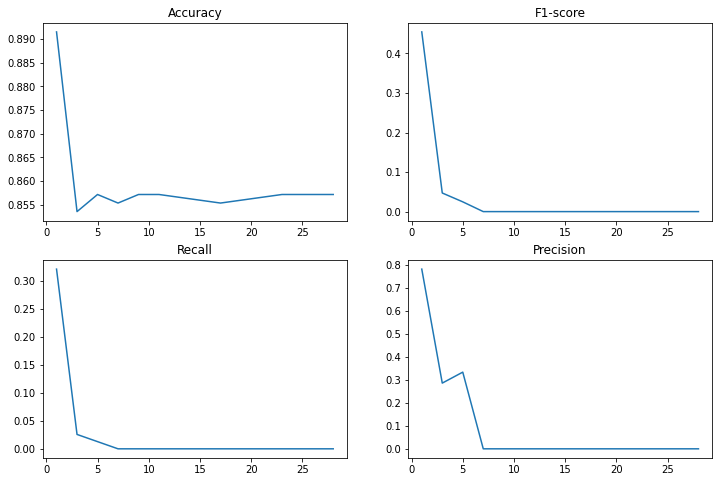

In [65]:
plt.subplots_adjust(left=1.5, bottom=1.5, right=2, top=2, wspace=1, hspace=1)
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(cos_k_val,cos_acc)
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(cos_k_val,cos_f1)
plt.title('F1-score')

plt.subplot(2, 2, 3)
plt.plot(cos_k_val,cos_re)
plt.title('Recall')

plt.subplot(2, 2, 4)
plt.plot(cos_k_val,cos_pr)
plt.title('Precision')

plt.show()

### Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)

***Compare both the models result.***

***What is the time complexity of training using KNN classifier?***

***What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?***